# PART A: Reinforcement Learning Fundamentals and Exploration Inefficiency


## Reinforcement Learning Basics

- In reinforcement learning (RL), an agent interacts with the environment, taking actions $a$, receiving a reward $r$, and moving to a new state $s$ 
- The agent is tasked with maximizing the accumulated rewards or returns $R$ over time by finding optimal actions (policy) 
<p align="center">
<br/>
<img src="./RLbasics.gif", width="300">
<p>


## Exploration in RL

- Any RL algorithm requires exploration phase to collect data for training the policy or value functions
- A good exploration phase will make the learning feasible or more efficient
<p align="center">
<br/>
<img src="./exp_in_rl.JPG", width="500">
<p>



## Classic Exploration
-  Most are specifically designed for bandit problems, and thus, they are hard to apply in large-scale or high-dimensional problems (e.g., Atari games), resulting in increased computational demands that can be impractical 

- These methods heavily rely on specific assumptions about reward distributions or system dynamics, limiting their adaptability when assumptions do not hold   

- They may struggle in dynamic environments with complex reward structures or frequent changes, leading to suboptimal performance. However, their simplicity make them suitable for bandit setting.  



## Multi-Armed Bandit Problem 

- In this problem, a machine with multiple arms is given. Pulling an arm results in a reward
- Each machine offers a random reward based on a unique probability distribution, which is not known beforehand
- The goal is to maximize the total rewards accumulated over a series of lever pulls
- The multi-armed bandit problem epitomizes the exploration-exploitation tradeoff dilemma within reinforcement learning
- Unlike general RL scenarios, actions chosen in bandit problems do not influence the reward distribution of the arms

## Problem Formulation
- Mathematically, given reward distrbutions of the bandit arms $B=\{R_1, R_2, ..., R_k\}$, each distribution being associated with the rewards delivered by one of the ${\displaystyle K\in \mathbb {N} ^{+}}$. The agent iteratively plays one lever per round and observes the associated reward $r_t$. The objective is to maximize the sum of the collected rewards. The horizon ${\displaystyle H}$ refers to the remaining number of rounds to be played
- The regret ${\displaystyle \rho }$ after ${\displaystyle T}$ rounds is defined as the expected difference between the reward sum associated with an optimal strategy (always choosing the best arm) and the sum of the collected rewards:
$$
\rho=T\mu^*-\sum_{t=1}^Tr_t
$$ 
where 
$\mu^*$ is the maximal reward mean ${\displaystyle \mu ^{*}=\max _{k}\{\mu _{k}\}}$ and ${\displaystyle {{r}}_{t}}$ is the reward in round t
- The goal can be casted to minizing the regret $\rho$

<p align="center">
<br/>
<img src="./mab.jpg", width="500">
<p>


## Implemntation of Multi-arm Bandit 
### The BanditArm Class

In [1]:
# Code adapted from: https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits
import random
import numpy as np
# display all floating point numbers to 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize


class BanditArm:
    """ the base arm class """
    
    def __init__(self, q):                
        self.q = q        # the true reward value              
        self.initialize() # reset the arm
        
    def initialize(self):
        self.Q = 0   # the estimate of this arm's reward value                
        self.n = 0   # the number of times this arm has been tried        
    
    def pull(self):
        """ return a random amount of reward """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
                    
    def update(self,R):
        """ update this arm statistics after it has returned reward value 'R' """     
    
        # increment the number of times this arm has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R
    
    def sample(self,t):
        """ return an estimate of the arm's reward value """
        return self.Q

### The ArmTester Class

In [2]:

"""
    Helper Functions
"""

# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)

def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))


class ArmTester():
    """ create and test a set of arms over a single test run """

    def __init__(self, arm_order, arm=BanditArm, multiplier=2, **kwargs ):  
        
        # create arms with a mean value defined by arm order 
        self.arms = [arm((q*multiplier)+2, **kwargs) for q in arm_order]     
        
        # set the number of arms equal to the number created
        self.number_of_arms = len(self.arms)           

        self.optimal_arm_index = np.argmax(arm_order)   
        
        # by default a arm tester records 2 bits of information over a run
        self.number_of_stats = kwargs.pop('number_of_stats', 2)       
             
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.arm_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_arms, 
                                            self.number_of_stats))
        
        # ensure that all arms are re-initialized
        for arm in self.arms: arm.initialize()

    def pull_and_update(self,arm_index):
        """ pull & update the specified arm and associated parameters """
        
        # pull the chosen arm and update its mean reward value
        reward = self.arms[arm_index].pull()
        self.arms[arm_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_arm_stats( self, t ):
        """ get the current information from each arm """        
        arm_stats = [[arm.Q, arm.n] for arm in self.arms]
        return arm_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each arm's reward at each timestep of the run """
        return self.arm_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each arm at each timestep of the run """
        return self.arm_stats[:,:,1]          
                
    def get_arm_percentages( self ):
        """ get the percentage of times each arm was tried over the run """
        return (self.arm_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_optimal_arm_percentage( self ):
        """ get the percentage of times the optimal arm was tried """        
        final_trials = self.arm_stats[:,:,1][self.total_steps]
        return (final_trials[self.optimal_arm_index]/self.total_steps)
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_arm( self, t ):
        """ Greedy Selection"""
        
        # choose the arm with the current highest mean reward or arbitrarily
        # select an arm in the case of a tie            
        arm_index = random_argmax([arm.sample(t+1) for arm in self.arms]) 
        return arm_index     
    
    
    def run( self, number_of_steps, maximum_total_reward = float('inf')):  
        """ perform a single run, over the set of arms, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(number_of_steps)
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all arms at the start of the time step
            self.arm_stats[t] = self.get_arm_stats(t)            
            
            # select an arm
            arm_index = self.select_arm(t)
            
            # pull the chosen arm and update its mean reward value
            self.pull_and_update(arm_index)
            
            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break
       
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each arm at the end of the run        
        self.arm_stats[t+1] = self.get_arm_stats(t+1)           
        
        return self.total_steps, self.total_reward

### The BanditEvironment Class

In [3]:
class BanditEvironment():
    """ setup and run repeated arm tests to get the average results """
    
    def __init__(self, 
                 arm_tester = ArmTester,
                 number_of_tests = 1000,
                 number_of_steps = 30,                      
                 maximum_total_reward = float('inf'),
                 **kwargs ):  
        
        self.arm_tester = arm_tester
        self.number_of_tests = number_of_tests
        self.number_of_steps = number_of_steps    
        self.maximum_total_reward = maximum_total_reward
        self.number_of_arms = self.arm_tester.number_of_arms
                
    def initialize_run(self):
        
        # keep track of the average values over the run
        self.mean_total_reward = 0.
        self.optimal_selected = 0.                
        self.mean_time_steps = 0.
        self.arm_percentages = np.zeros(self.number_of_arms)   
        self.estimates = np.zeros(shape=(self.number_of_steps+1,self.number_of_arms))        
        self.number_of_trials = np.zeros(shape=(self.number_of_steps+1,self.number_of_arms))
        
        # the cumulative total reward per timestep
        self.cumulative_reward_per_timestep = np.zeros(shape=(self.number_of_steps))
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = np.zeros(shape=(self.number_of_steps))
        
    def get_mean_total_reward(self):
        """ the final total reward averaged over the number of timesteps """
        return self.mean_total_reward
    
    def get_cumulative_reward_per_timestep(self):
        """ the cumulative total reward per timestep """
        return self.cumulative_reward_per_timestep
    
    def get_reward_per_timestep(self):
        """ the mean actual reward obtained at each timestep """
        return self.reward_per_timestep

    def get_optimal_selected(self):
        """ the mean times the optimal arm was selected """
        return self.optimal_selected

    def get_arm_percentages(self): 
        """ the mean of the percentage times each arm was selected """
        return self.arm_percentages
    
    def get_estimates(self):
        """ per arm reward estimates """
        return self.estimates
    
    def get_number_of_trials(self):
        """ per arm number of trials """
        return self.number_of_trials  
    
    def get_mean_time_steps(self):
        """ the average number of trials of each test """
        return self.mean_time_steps
    
    def update_mean( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value """
        return (1 - 1.0/n) * current_mean + (1.0/n) * new_value

    def update_mean_array( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value for an array """

        new_value = np.array(new_value)
        
        # pad the new array with its last value to make sure its the same length as the original           
        pad_length = (current_mean.shape[0] - new_value.shape[0])               
        
        if pad_length > 0:
            new_array = np.pad(new_value,(0,pad_length), mode='constant', constant_values=new_value[-1])
        else:
            new_array = new_value
    
        return (1 - 1.0/n) * current_mean + (1.0/n) * new_array
        
    def record_test_stats(self,n):
        """ update the mean value for each statistic being tracked over a run """

        # calculate the new means from the old means and the new value
        tester = self.arm_tester
        self.mean_total_reward = self.update_mean( self.mean_total_reward, tester.get_mean_reward(), n)
        self.optimal_selected = self.update_mean( self.optimal_selected, tester.get_optimal_arm_percentage(), n)
        self.arm_percentages = self.update_mean( self.arm_percentages, tester.get_arm_percentages(), n)        
        self.mean_time_steps = self.update_mean( self.mean_time_steps, tester.get_time_steps(), n)
        
        self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep, 
                                                                      tester.get_total_reward_per_timestep(), n)        

        # check if the tests are only running until a maximum reward value is reached
        if self.maximum_total_reward == float('inf'):

            self.estimates = self.update_mean_array( self.estimates, tester.get_estimates(), n)        
            self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep, 
                                                                          tester.get_total_reward_per_timestep(), n)
            self.reward_per_timestep = self.update_mean_array( self.reward_per_timestep, tester.get_reward_per_timestep(), n)
            self.number_of_trials = self.update_mean_array( self.number_of_trials, tester.get_number_of_trials(), n)
    
    def run(self):
        """ repeat the test over a set of arms for the specified number of trials """
                    
        # do the specified number of runs for a single test
        self.initialize_run()
        for n in tqdm(range(1,self.number_of_tests+1)):

            # do one run of the test                               
            self.arm_tester.run( self.number_of_steps, self.maximum_total_reward )
            self.record_test_stats(n)                         
           

### Finally, let's define the experiment running function

In [4]:
def run_multiple_tests( tester, max_steps = 500, show_arm_percentages = True ):
    mean_rewards = []
    number_of_tests = 500
    number_of_steps = max_steps
    maximum_total_reward = 800

    experiment = BanditEvironment(arm_tester   = tester,
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps,
                                  maximum_total_reward = maximum_total_reward)
    experiment.run()

    print(f'Mean Reward per Time Step = {experiment.get_mean_total_reward():0.3f}')
    print(f'Optimal Arm Selected = {experiment.get_optimal_selected():0.3f}')    
    print(f'Average Number of Trials Per Run = {experiment.get_mean_time_steps():0.3f}')
    if show_arm_percentages:
      print(f'Arm Percentages = {experiment.get_arm_percentages()}') 
        
    mean_rewards.append(f"{experiment.get_mean_total_reward():0.3f}")
    return experiment.get_cumulative_reward_per_timestep()

### Let's test the default greedy strategy

In [5]:
# create 5 arms in a fixed order
ARM_ORDER = [2,1,3,5,4]
MULTIPLIER = 0.1
np.random.seed(0)
random.seed(0)

Given the order, the true values for the arms are defined by this fixed rule:

In [6]:
print([(q*MULTIPLIER) for q in ARM_ORDER])  

[0.2, 0.1, 0.30000000000000004, 0.5, 0.4]


This mean the optimal arm is:  

In [7]:
print(np.argmax([(q*MULTIPLIER)+2 for q in ARM_ORDER]))

3


In [8]:

# Greedy Selection
greedy_result = run_multiple_tests(ArmTester(ARM_ORDER, BanditArm, MULTIPLIER ) )

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 97.80it/s]

Mean Reward per Time Step = 2.321
Optimal Arm Selected = 0.214
Average Number of Trials Per Run = 346.776
Arm Percentages = [0.208 0.184 0.176 0.214 0.218]


### Let's implement a better approach: $\epsilon$-greedy

In [9]:
class EpsilonGreedySelectionTester( ArmTester ):

    def __init__(self, arm_order, multiplier, epsilon = 0.2 ):  
        
        # create a standard arm tester
        super().__init__(arm_order=arm_order, multiplier=multiplier) 
        
        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon
    
    
    def select_arm( self, t ):
        """ Epsilon-Greedy Arm Selection"""
        
        # probability of selecting a random arm
        p = np.random.random()

        # if the probability is less than epsilon then a random arm is chosen from the complete set
        if p < self.epsilon:
            arm_index = np.random.choice(self.number_of_arms)
        else:
            # choose the arm with the current highest mean reward or arbitrary select a arm in the case of a tie            
            arm_index = random_argmax([arm.sample(t) for arm in self.arms])               
        
        return arm_index

### Let's test $\epsilon$-greedy

In [10]:
# Epsilon Greedy
_ = run_multiple_tests(EpsilonGreedySelectionTester(ARM_ORDER, MULTIPLIER, epsilon = 0.8 ) )

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 116.50it/s]

Mean Reward per Time Step = 2.336
Optimal Arm Selected = 0.275
Average Number of Trials Per Run = 343.228
Arm Percentages = [0.171 0.166 0.179 0.275 0.210]


We can tune $\epsilon$ to improve the performance further. Note that:
- $\epsilon=0$: Greedy Selection
- $\epsilon=1$: Random Selection
- Normally, a balanced $0<\epsilon<1$ will be the best

In [11]:
for e in [0.0,0.2,0.4,0.6,0.8,1.0]:
    print(f"---STATISTICS For Epsilon-Greedy (e={e})--")
    run_multiple_tests(EpsilonGreedySelectionTester(ARM_ORDER, MULTIPLIER, epsilon = e ) )

  2%|█▉                                                                              | 12/500 [00:00<00:04, 106.82it/s]

---STATISTICS For Epsilon-Greedy (e=0.0)--


  2%|█▌                                                                               | 10/500 [00:00<00:05, 96.80it/s]

Mean Reward per Time Step = 2.308
Optimal Arm Selected = 0.196
Average Number of Trials Per Run = 348.730
Arm Percentages = [0.216 0.208 0.192 0.196 0.188]
---STATISTICS For Epsilon-Greedy (e=0.2)--


  3%|██▏                                                                             | 14/500 [00:00<00:03, 122.70it/s]

Mean Reward per Time Step = 2.402
Optimal Arm Selected = 0.442
Average Number of Trials Per Run = 334.058
Arm Percentages = [0.091 0.064 0.141 0.442 0.262]
---STATISTICS For Epsilon-Greedy (e=0.4)--


  3%|██▍                                                                             | 15/500 [00:00<00:03, 139.33it/s]

Mean Reward per Time Step = 2.385
Optimal Arm Selected = 0.400
Average Number of Trials Per Run = 336.296
Arm Percentages = [0.110 0.096 0.142 0.400 0.251]
---STATISTICS For Epsilon-Greedy (e=0.6)--


  3%|██▍                                                                             | 15/500 [00:00<00:03, 136.79it/s]

Mean Reward per Time Step = 2.362
Optimal Arm Selected = 0.343
Average Number of Trials Per Run = 339.462
Arm Percentages = [0.142 0.130 0.164 0.343 0.221]
---STATISTICS For Epsilon-Greedy (e=0.8)--


  3%|██▍                                                                             | 15/500 [00:00<00:03, 129.87it/s]

Mean Reward per Time Step = 2.334
Optimal Arm Selected = 0.266
Average Number of Trials Per Run = 343.464
Arm Percentages = [0.170 0.166 0.184 0.266 0.214]
---STATISTICS For Epsilon-Greedy (e=1.0)--


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 138.95it/s]

Mean Reward per Time Step = 2.312
Optimal Arm Selected = 0.202
Average Number of Trials Per Run = 346.758
Arm Percentages = [0.198 0.200 0.200 0.202 0.200]


As we can see, for this specific ARM_ORDER, only some $\epsilon$ show clearly better results than Greedy. They can somehow identify the best arm, indicated by a higher percentage.  


In [12]:
epsilon_greedy_result = run_multiple_tests(EpsilonGreedySelectionTester(ARM_ORDER, MULTIPLIER, epsilon = 0.4 ) )

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 100.66it/s]

Mean Reward per Time Step = 2.386
Optimal Arm Selected = 0.396
Average Number of Trials Per Run = 336.164
Arm Percentages = [0.112 0.099 0.154 0.396 0.238]


Now we start implementing some advanced baselines.

### The Upper Confidence Bound (UCB) Exploring Strategy

In [13]:
class UCBArm( BanditArm ):

    def __init__( self, q, **kwargs ):    
        """ initialize the UCB arm """                  
        
        # store the confidence level controlling exploration -- corresponding to hyperparameter c in the slides
        self.c = kwargs.pop('confidence_level', 2.0)       
                
        # pass the true reward value to the base class  
        super().__init__(q)           
        
    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this arm's mean """
        
 
        return self.c * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

### The Thompson Sampling Exploring Strategy

Here we need to assume the reward distribution is Gaussian, which is correct in our experiment setting. 

In [14]:
class GaussianThompsonArm( BanditArm ):
    def __init__(self, q):                
                
        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean
        
        # pass the true reward value to the base class             
        super().__init__(q)         
        
    def sample(self,t):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0    
                    
    def update(self,R):
        """ update this arm after it has returned reward value 'R' """   

        # do a standard update of the estimated mean
        super().update(R)    
               
        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)        
        self.τ_0 += 1       

### Let's test the new methods. For UCB, we can try to tune confidence level c

In [15]:
# UCB
for c in [0.0,0.2,0.4,0.6]:
    print(f"---STATISTICS For UCB (c={c})--")
    run_multiple_tests( ArmTester(ARM_ORDER, UCBArm, MULTIPLIER, confidence_level = c ))


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\thaihung\.conda\envs\test_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\thaihung\.conda\envs\test_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
  1%|█▏                                                                                | 7/500 [00:00<00:07, 64.16it/s]

---STATISTICS For UCB (c=0.0)--


  1%|▉                                                                                 | 6/500 [00:00<00:11, 41.87it/s]

Mean Reward per Time Step = 2.213
Optimal Arm Selected = 0.000
Average Number of Trials Per Run = 362.284
Arm Percentages = [1.000 0.000 0.000 0.000 0.000]
---STATISTICS For UCB (c=0.2)--


  1%|▉                                                                                 | 6/500 [00:00<00:08, 54.89it/s]

Mean Reward per Time Step = 2.413
Optimal Arm Selected = 0.451
Average Number of Trials Per Run = 332.876
Arm Percentages = [0.080 0.050 0.151 0.451 0.268]
---STATISTICS For UCB (c=0.4)--


  2%|█▎                                                                                | 8/500 [00:00<00:06, 78.02it/s]

Mean Reward per Time Step = 2.429
Optimal Arm Selected = 0.487
Average Number of Trials Per Run = 330.420
Arm Percentages = [0.062 0.032 0.158 0.487 0.262]
---STATISTICS For UCB (c=0.6)--


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 55.79it/s]

Mean Reward per Time Step = 2.430
Optimal Arm Selected = 0.515
Average Number of Trials Per Run = 330.180
Arm Percentages = [0.058 0.037 0.117 0.515 0.274]


In [16]:
ucb_result = run_multiple_tests( ArmTester(ARM_ORDER, UCBArm, MULTIPLIER, confidence_level = 0.6 ))

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\thaihung\.conda\envs\test_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\thaihung\.conda\envs\test_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 56.85it/s]

Mean Reward per Time Step = 2.422
Optimal Arm Selected = 0.491
Average Number of Trials Per Run = 331.346
Arm Percentages = [0.073 0.044 0.136 0.491 0.256]


In [17]:
# Thompson Sampling
print(f"---STATISTICS For Thompson Sampling--")
thompson_sampling_result = run_multiple_tests( ArmTester(ARM_ORDER, GaussianThompsonArm, MULTIPLIER ))

  2%|█▍                                                                                | 9/500 [00:00<00:07, 69.55it/s]

---STATISTICS For Thompson Sampling--


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 66.45it/s]

Mean Reward per Time Step = 2.511
Optimal Arm Selected = 0.991
Average Number of Trials Per Run = 319.374
Arm Percentages = [0.000 0.001 0.001 0.991 0.007]


As we can see, UCB and Thompson Sampling can easily determine the optimal arm. Reducing MULTIPLER will make the problem harder. 

### Result Summary

Text(0, 0.5, 'Mean Total Reward')

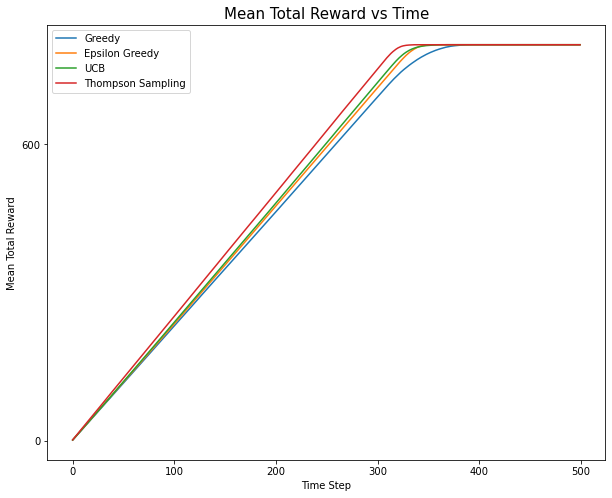

In [18]:
test_names = ['Greedy','Epsilon Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))
rewards = [greedy_result, epsilon_greedy_result, ucb_result, thompson_sampling_result]
for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')
    
plt.legend()    
plt.title('Mean Total Reward vs Time', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward')